# Margnetisation

Read all results from the CE and check magnetisations. We can take this as an indication of valance state. Mn3+ is a d(4) ion and Ni3+ is d(7). In high-spin configuration, one therefore expects mu=4 and mu=3 for Mn and Ni. If there is internal charge disproportionation into Mn4+ and Ni3+, this would change to d(3) / mu=3 and d(8) / mu=2 for a transfer from Mn to Ni.

In [5]:
import json,os
from scipy.spatial import ConvexHull
import numpy as np
import pandas as pd

def read_properties(folder):
    '''
    Reads all properties files found in the subtree of folder
    '''
    
    # Walk the directory tree and find all properties files
    properties = []
    properties_files = []
    for root, dirs, files in os.walk(folder):
        path = root.split(os.sep)
        
        for file in files:
            if "properties.calc.json" in file:
                properties_files.append(os.path.join(root, file))

    
    for file in properties_files:
        
        path = file.split(os.sep)
        n = len(path)

        with open(file, 'r') as f:
            ds = json.load(f)
            ds['configname'] = path[n-4]+"/"+path[n-3]
            properties.append(ds)
    
    return properties

def reduce_mag(properties):
    '''
    Extracts avg. magnetisation per TM site from all configurations
    '''
      
    result= []
 
    for p in properties:
        n = 0
        
        # Dict of num atoms per type - n
        # Dict of atom indices per type = v
        d = 0; v = {}; n = {'La':0,'Ni':0,'Mn':0,'O':0}
        for f in zip(p['atom_type'],p['atoms_per_type']):
            n[f[0]] = f[1]
            v[f[0]] = [d+r for r in range(f[1])]
            d += f[1]
        
        # Calculate concentration
        conc = float(n['Ni']) / float(n['Ni']+n['Mn'])

        mag = {'mag_La':0.0,'mag_Ni':0.0,'mag_Mn':0.0,'mag_O':0.0,'configname': p['configname']}
        for atomtype,indices in v.items():
            mag['mag_'+atomtype] = np.average([p['relaxed_mag_basis'][i] for i in indices])
            mag['conc'] = conc
        result.append(mag)
    return result

def distance_from_hull(df):
    '''
    Computes the distance from the hull for a set of points (conc, form_energy)
    '''
    
    
    
    points = np.array([[v[0],v[1]] for v in zip(df['comp(a)'],df['formation_energy'])])
    hull = ConvexHull(points)
    
    dist = np.array([])
    configs = np.array([])
    points = [v for v in zip(df['comp(a)'],df['formation_energy'],df['configname'])]
    for p in points:
        for simplex in hull.simplices:
            conc = p[0]
            energy = p[1]
            config = p[2]
            conc_a = points[simplex[0]][0]; energy_a = points[simplex[0]][1]
            conc_b = points[simplex[1]][0]; energy_b = points[simplex[1]][1]
            
            if conc_a > conc_b:
                (conc_b,conc_a) = (conc_a,conc_b)
                (energy_b,energy_a) = (energy_a,energy_b)
            
            if p[0] >= conc_a and p[0] <= conc_b:
                energy_hull = energy_a + (conc-conc_a)/(conc_b-conc_a)*(energy_b-energy_a)

                if (energy >= energy_hull) and not np.any(configs == config):
                    dist = np.append(dist, energy-energy_hull)
                    configs = np.append(configs, config)
    
    return pd.Series(dist, index=configs)

## Read and process data

In [6]:
d = read_properties("../training_data")
mag = pd.DataFrame(reduce_mag(d))
mag = mag.set_index('configname')
df=pd.read_fwf('../fit_1/summary.dat',header=0)
df = df.set_index(df['configname'])
df = df.drop(['#'], axis=1)
df['mag_Mn'] = mag['mag_Mn']
df['mag_Ni'] = mag['mag_Ni']
df['dist_hull'] = distance_from_hull(df).rename('dist_hull')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:90: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


## Plot magnetisation as function of concentration

(1.2, 2)

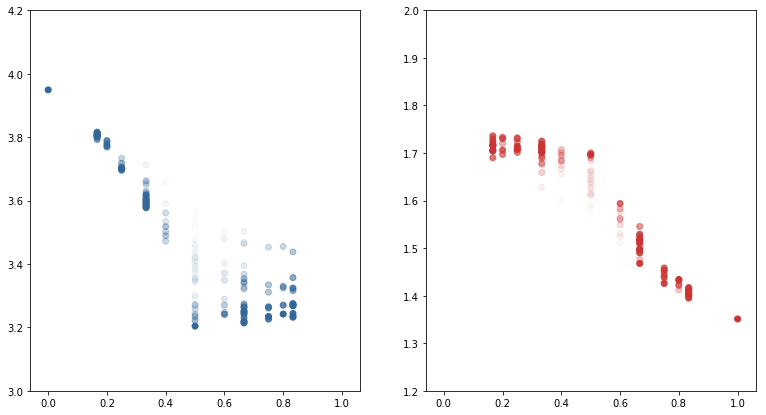

In [7]:
import matplotlib.pyplot as plt
import math

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(13,7))

dotcolors=[(0.2, 0.4, 0.6, math.exp(-a/0.05)) for a in df['dist_hull']]
ax1.scatter(df['comp(a)'],df['mag_Mn'],c=dotcolors)
dotcolors=[(0.8, 0.2, 0.2, math.exp(-a/0.05)) for a in df['dist_hull']]
ax2.scatter(df['comp(a)'],df['mag_Ni'],c=dotcolors)
ax1.set_ylim([3,4.2])
ax2.set_ylim([1.2,2])

The left-hand plot shows magnetisation of Mn centres as function of concentration. The left-hand plot shows the same for Ni centres. Starting from mu=4 for LaMnO3, magnetisation of Mn gradually reduces down to a Mn:Ni ratio of 1:1 after which it stays constant. This can be interpreted as a gradual change of valence from Mn3+ to Mn4+. The Ni center shows as similar trend but at a reduce magnitude. The magnetisatioon increases from about 1.4 for LaNiO3 to about 1.8. 